In [1]:
# plot_sub04_ses01_run01.py
# Usage:
#   python plot_sub04_ses01_run01.py
# Assumes the FIF exists at:
#   datasets/bnci_horizon_2020_ErrP/raw_fif/sub-04/ses-01/sub-04_ses-01_task-errp_run-01_raw.fif

from __future__ import annotations

from pathlib import Path
import numpy as np
import mne
import matplotlib.pyplot as plt


FIF_PATH = Path(
    "datasets/bnci_horizon_2020_ErrP/raw_fif/sub-04/ses-01/sub-04_ses-01_task-errp_run-01_raw.fif"
)

OUT_DIR = Path("datasets/bnci_horizon_2020_ErrP/qc_outputs/quickplots/sub-04_ses-01_run-01")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# Plot knobs
SNIPPET_SEC = 10.0          # small view from start
OVERVIEW_MAX_POINTS = 30000 # cap timepoints plotted per channel for whole-run overview
MAX_CHANNELS = 20           # plot first N EEG channels

# Optionally drop channels from the plot (e.g., suspected dead electrode)
DROP_CHS = {"Fp1"}          # set() to keep everything


def pick_eeg(raw: mne.io.BaseRaw, max_channels: int) -> list[int]:
    picks = mne.pick_types(raw.info, eeg=True, meg=False, eog=False, stim=False, misc=False)
    # keep ordering as in raw.ch_names; just limit count
    picks = picks[: min(max_channels, len(picks))]
    if DROP_CHS:
        picks = [p for p in picks if raw.ch_names[p] not in DROP_CHS]
    return picks


def robust_scale(x: np.ndarray) -> float:
    """Robust global scale using MAD; falls back to std."""
    med = np.median(x)
    mad = np.median(np.abs(x - med))
    scale = 6 * mad
    if not np.isfinite(scale) or scale <= 0:
        s = np.std(x)
        scale = s if np.isfinite(s) and s > 0 else 1e-6
    return float(scale)


def plot_snippet(raw: mne.io.BaseRaw, out_path: Path, duration_sec: float) -> None:
    sfreq = float(raw.info["sfreq"])
    stop = max(1, min(int(raw.n_times), int(round(duration_sec * sfreq))))
    picks = pick_eeg(raw, MAX_CHANNELS)

    data = raw.get_data(picks=picks, start=0, stop=stop)
    times = np.arange(data.shape[1]) / sfreq

    # Per-channel median-center to remove DC offsets
    data_c = data - np.median(data, axis=1, keepdims=True)

    scale = robust_scale(data_c)

    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111)

    offsets = np.arange(len(picks))[::-1]
    for i, p in enumerate(picks):
        ax.plot(times, data_c[i] / scale + offsets[i], linewidth=0.8)

    ax.set_yticks(offsets)
    ax.set_yticklabels([raw.ch_names[p] for p in picks])
    ax.set_xlabel("Time (s)")
    ax.set_title(f"sub-04 ses-01 run-01 | snippet {duration_sec:.1f}s | centered | scale={scale:.3g} V")
    ax.grid(True, alpha=0.2)

    fig.tight_layout()
    fig.savefig(out_path, dpi=150)
    plt.close(fig)


def plot_overview(raw: mne.io.BaseRaw, out_path: Path, max_points: int) -> None:
    sfreq = float(raw.info["sfreq"])
    n_times = int(raw.n_times)
    picks = pick_eeg(raw, MAX_CHANNELS)

    decim = int(np.ceil(n_times / max_points)) if n_times > max_points else 1

    data = raw.get_data(picks=picks, start=0, stop=n_times)
    data = data[:, ::decim]
    times = (np.arange(data.shape[1]) * decim) / sfreq

    data_c = data - np.median(data, axis=1, keepdims=True)
    scale = robust_scale(data_c)

    fig = plt.figure(figsize=(14, 10))
    ax = fig.add_subplot(111)

    offsets = np.arange(len(picks))[::-1]
    for i, p in enumerate(picks):
        ax.plot(times, data_c[i] / scale + offsets[i], linewidth=0.5)

    ax.set_yticks(offsets)
    ax.set_yticklabels([raw.ch_names[p] for p in picks])
    ax.set_xlabel("Time (s)")
    ax.set_title(
        f"sub-04 ses-01 run-01 | overview (entire run) | decim={decim} | centered | scale={scale:.3g} V"
    )
    ax.grid(True, alpha=0.2)

    fig.tight_layout()
    fig.savefig(out_path, dpi=150)
    plt.close(fig)


def plot_psd(raw: mne.io.BaseRaw, out_path: Path, fmin: float = 0.1, fmax: float = 40.0) -> None:
    # PSD can be slow; this uses MNE's compute_psd and saves the figure
    psd = raw.compute_psd(fmin=fmin, fmax=fmax)
    fig = psd.plot(show=False)
    fig.savefig(out_path, dpi=150)
    plt.close(fig)


def main() -> None:
    if not FIF_PATH.exists():
        raise FileNotFoundError(f"Missing: {FIF_PATH}")

    raw = mne.io.read_raw_fif(FIF_PATH, preload=False, verbose="ERROR")

    print("Loaded:", FIF_PATH)
    print("sfreq:", raw.info["sfreq"], "Hz")
    print("n_times:", raw.n_times, "| duration:", raw.n_times / raw.info["sfreq"], "sec")
    if DROP_CHS:
        print("Dropping channels from plots:", sorted(DROP_CHS))

    plot_snippet(raw, OUT_DIR / "raw_snippet_10s.png", duration_sec=SNIPPET_SEC)
    plot_overview(raw, OUT_DIR / "raw_overview.png", max_points=OVERVIEW_MAX_POINTS)
    plot_psd(raw, OUT_DIR / "psd_0.1-40Hz.png", fmin=0.1, fmax=40.0)

    print("Wrote:")
    print(" -", (OUT_DIR / "raw_snippet_10s.png").resolve())
    print(" -", (OUT_DIR / "raw_overview.png").resolve())
    print(" -", (OUT_DIR / "psd_0.1-40Hz.png").resolve())


if __name__ == "__main__":
    main()

Loaded: datasets/bnci_horizon_2020_ErrP/raw_fif/sub-04/ses-01/sub-04_ses-01_task-errp_run-01_raw.fif
sfreq: 512.0 Hz
n_times: 88576 | duration: 173.0 sec
Dropping channels from plots: ['Fp1']
Effective window size : 4.000 (s)
Plotting power spectral density (dB=True).
Wrote:
 - /Library/WebServer/Sites/ErrP1/datasets/bnci_horizon_2020_ErrP/qc_outputs/quickplots/sub-04_ses-01_run-01/raw_snippet_10s.png
 - /Library/WebServer/Sites/ErrP1/datasets/bnci_horizon_2020_ErrP/qc_outputs/quickplots/sub-04_ses-01_run-01/raw_overview.png
 - /Library/WebServer/Sites/ErrP1/datasets/bnci_horizon_2020_ErrP/qc_outputs/quickplots/sub-04_ses-01_run-01/psd_0.1-40Hz.png


Reading 0 ... 88575  =      0.000 ...   172.998 secs...


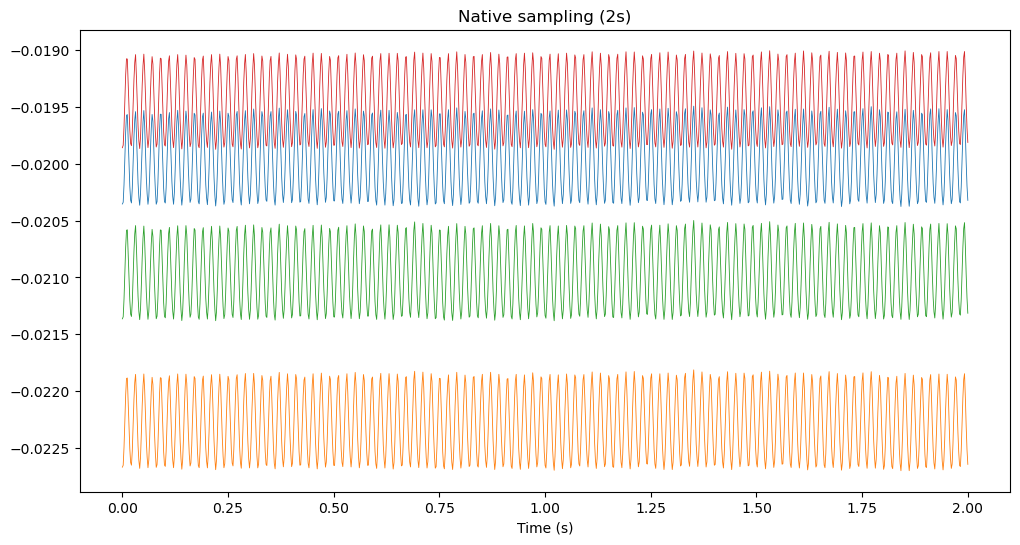

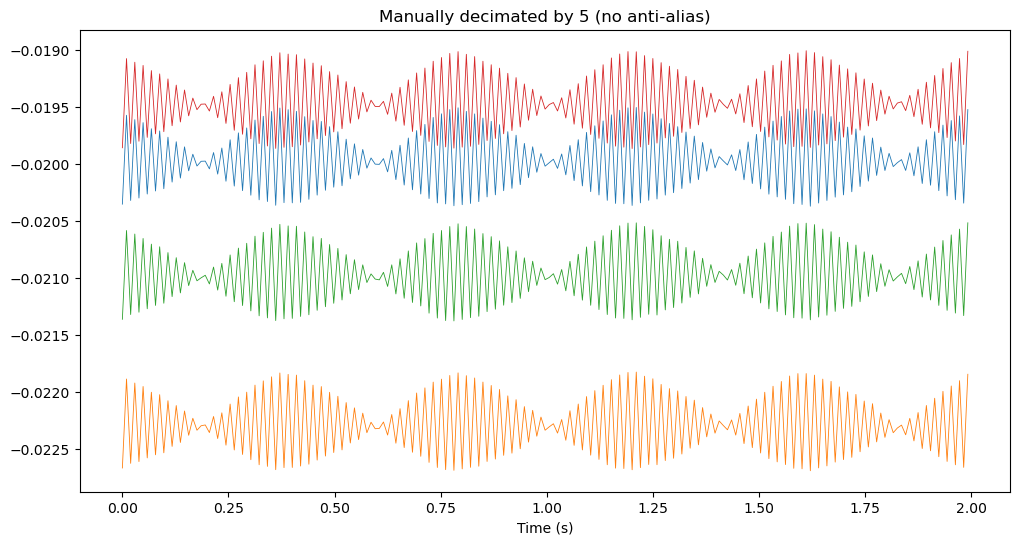

In [2]:
import mne
import numpy as np
import matplotlib.pyplot as plt

fif = "datasets/bnci_horizon_2020_ErrP/raw_fif/sub-04/ses-01/sub-04_ses-01_task-errp_run-01_raw.fif"
raw = mne.io.read_raw_fif(fif, preload=False, verbose="ERROR")

chs = ["AF7", "F1", "FCz", "Pz"]  # swap in channels that look stripy
raw2 = raw.copy().pick(chs).load_data().crop(tmin=10, tmax=12)  # 2s window

sfreq = raw2.info["sfreq"]
x = raw2.get_data()  # shape (n_ch, n_t)
t = raw2.times

# emulate your overview decimation factor
max_points = 20000
n_times_full = raw.n_times
decim = int(np.ceil(n_times_full / max_points)) if n_times_full > max_points else 1

x_dec = x[:, ::decim]
t_dec = t[::decim]

plt.figure(figsize=(12, 6))
for i, ch in enumerate(chs):
    plt.plot(t, x[i] + i*0.001, linewidth=0.6)      # offset for visibility
plt.title("Native sampling (2s)")
plt.xlabel("Time (s)")
plt.show()

plt.figure(figsize=(12, 6))
for i, ch in enumerate(chs):
    plt.plot(t_dec, x_dec[i] + i*0.001, linewidth=0.6)
plt.title(f"Manually decimated by {decim} (no anti-alias)")
plt.xlabel("Time (s)")
plt.show()

In [7]:
from pathlib import Path
import numpy as np
import mne
import matplotlib.pyplot as plt

FIF_PATH = Path(
    "datasets/bnci_horizon_2020_ErrP/raw_fif/sub-04/ses-01/sub-04_ses-01_task-errp_run-01_raw.fif"
)

# Change output folder name so you don’t overwrite your notch results
OUT_DIR = Path("datasets/bnci_horizon_2020_ErrP/qc_outputs/quickplots/sub-04_ses-01_run-01-lowpass30")
OUT_DIR.mkdir(parents=True, exist_ok=True)

PSD_FMIN = 0.1
PSD_FMAX = 120.0   # keep high to verify removal of 50/100 etc after lowpass
SNIPPET_SEC = 10.0

LOWPASS_HZ = 30.0  # <-- requested


def save_psd(raw: mne.io.BaseRaw, label: str):
    psd = raw.compute_psd(fmin=PSD_FMIN, fmax=PSD_FMAX)
    fig = psd.plot(show=False, average=False)
    fig.suptitle(f"PSD ({label})", y=1.02)
    out_path = OUT_DIR / f"psd_{label}_{PSD_FMIN:.1f}-{PSD_FMAX:.1f}Hz.png"
    fig.savefig(out_path, dpi=150, bbox_inches="tight")
    plt.close(fig)
    print("Wrote:", out_path)


def save_snippet(raw: mne.io.BaseRaw, label: str, picks=None):
    sfreq = float(raw.info["sfreq"])
    stop = int(round(SNIPPET_SEC * sfreq))

    if picks is None:
        picks = mne.pick_types(raw.info, eeg=True, meg=False, eog=False, stim=False, misc=False)
        #want = ["Fp1", "Fz", "Cz", "Pz", "Oz"]
        #picks = [raw.ch_names.index(ch) for ch in want if ch in raw.ch_names] + list(picks_all[:5])
        #seen = set()
        #picks = [p for p in picks if not (p in seen or seen.add(p))]

    data = raw.get_data(picks=picks, start=0, stop=stop)
    times = np.arange(data.shape[1]) / sfreq
    ch_names = [raw.ch_names[p] for p in picks]

    data = data - np.median(data, axis=1, keepdims=True)

    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(111)

    mad = np.median(np.abs(data - np.median(data)))
    scale = 6 * mad if mad > 0 else (np.std(data) if np.std(data) > 0 else 1e-6)

    offsets = np.arange(len(ch_names))[::-1]
    for i, ch in enumerate(ch_names):
        ax.plot(times, data[i] / scale + offsets[i], linewidth=0.8)

    ax.set_yticks(offsets)
    ax.set_yticklabels(ch_names)
    ax.set_xlabel("Time (s)")
    ax.set_title(f"Time snippet ({label}) – {SNIPPET_SEC:.1f}s")
    ax.grid(True, alpha=0.2)

    out_path = OUT_DIR / f"snippet_{label}_{SNIPPET_SEC:.1f}s.png"
    fig.tight_layout()
    fig.savefig(out_path, dpi=150)
    plt.close(fig)
    print("Wrote:", out_path)


def main():
    raw = mne.io.read_raw_fif(FIF_PATH, preload=True, verbose="ERROR")
    raw.pick_types(eeg=True, meg=False, eog=False, stim=False, misc=False)

    # 1) Before
    save_psd(raw, "before")
    save_snippet(raw, "before")

    # 2) Low-pass at 30 Hz
    # Note: using a copy so you keep the original raw untouched
    raw_lp = raw.copy().filter(
        l_freq=None,
        h_freq=LOWPASS_HZ,
        picks="eeg",
        method="fir",
        phase="zero",
        verbose="ERROR",
    )

    # 3) After low-pass
    save_psd(raw_lp, f"after_lowpass_{LOWPASS_HZ:g}Hz")
    save_snippet(raw_lp, f"after_lowpass_{LOWPASS_HZ:g}Hz")

    print("\nDone. Outputs in:", OUT_DIR.resolve())


if __name__ == "__main__":
    main()

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Effective window size : 4.000 (s)
Plotting power spectral density (dB=True).
Wrote: datasets/bnci_horizon_2020_ErrP/qc_outputs/quickplots/sub-04_ses-01_run-01-lowpass30/psd_before_0.1-120.0Hz.png
Wrote: datasets/bnci_horizon_2020_ErrP/qc_outputs/quickplots/sub-04_ses-01_run-01-lowpass30/snippet_before_10.0s.png
Effective window size : 4.000 (s)
Plotting power spectral density (dB=True).
Wrote: datasets/bnci_horizon_2020_ErrP/qc_outputs/quickplots/sub-04_ses-01_run-01-lowpass30/psd_after_lowpass_30Hz_0.1-120.0Hz.png
Wrote: datasets/bnci_horizon_2020_ErrP/qc_outputs/quickplots/sub-04_ses-01_run-01-lowpass30/snippet_after_lowpass_30Hz_10.0s.png

Done. Outputs in: /Library/WebServer/Sites/ErrP1/datasets/bnci_horizon_2020_ErrP/qc_outputs/quickplots/sub-04_ses-01_run-01-lowpass30
